In [107]:
#Module imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import os 

In [108]:
##Preprocessing##
#Read all input files into DataFrames 
formatted_dir = "formatted_input"
bpm_path = "{0}/19isolates_BPM.csv".format(formatted_dir)
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)
# dc_tpm_path = "{0}/dc2ndadd_merged_tpm_data.tsv".format(formatted_dir) #Deprecated dataset 
# rob_tpm_path = "{0}/rob3rd_merged_tpm_data.tsv".format(formatted_dir)
# dc_count_path = "{0}/dc2ndadd_merged_count_data.tsv".format(formatted_dir)
# rob_count_path = "{0}/rob3rd_merged_count_data.tsv".format(formatted_dir)
#Flexible whitespace parsing - tpm first column is tab separated then space separated 
# rob_tpm_df = pd.read_csv(rob_tpm_path,sep=r"\s+")
# dc_tpm_df = pd.read_csv(dc_tpm_path,sep=r"\s+")
# rob_count_df = pd.read_csv(rob_count_path,sep=r"\s+")
# dc_count_df = pd.read_csv(dc_count_path,sep=r"\s+")
count_4th_trial_path = "{0}/4thtrial_merged_count_data.tsv".format(formatted_dir)
tpm_4th_trial_path = "{0}/4thtrial_merged_tpm_data.tsv".format(formatted_dir)
count_4t_df = pd.read_csv(count_4th_trial_path,sep=r"\s+")
tpm_4t_df = pd.read_csv(tpm_4th_trial_path,sep=r"\s+")

bpm_df = pd.read_csv(bpm_path)
#Process GO annotations from semicolon separated string into list of entries for columns Functional Pathway and Phenotype
mcseed_df = pd.read_csv(mcseed_path)
for col in ["Functional pathway", "Phenotype"]:
    mcseed_df.loc[:,col] = mcseed_df.loc[:,col].str.split(";")

#Set indices: BPM -> Isolate name; mcseed -> Locus tag; TPM -> target_id (locus)
bpm_df.set_index("Isolate name",inplace=True)
mcseed_df.set_index("Locus tag",inplace=True)
# rob_tpm_df.set_index("target_id",inplace=True)
# dc_tpm_df.set_index("target_id",inplace=True)
# rob_count_df.set_index("target_id",inplace=True)
# dc_count_df.set_index("target_id",inplace=True)
count_4t_df.set_index("target_id",inplace=True)
tpm_4t_df.set_index("target_id",inplace=True)

bpm_df = bpm_df.transpose().drop(index="# functions")
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(bpm_df.columns,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, bpm_df.columns))

for strain in STRAIN_TAGS:
    strain_abbrev = STRAIN_TAGS[strain]
    if not (strain == "Blautia obeum Bg7063_SSTS2015" and strain_abbrev == "Rob"): 
        assert(strain[0] == strain_abbrev[0])

#BPM Summary statistics 
print("BPM=1 pathways by strain")
print(bpm_df.sum())
print("Total BPM=1 pathways: {0}".format(bpm_df.sum().sum()))

BPM=1 pathways by strain
Isolate name
Bifidobacterium breve Bgsng463_m5_93            46
Bifidobacterium catenulatum Bgsng468_m22_84     44
Bifidobacterium longum infantis 40721_2D9_SN    50
Blautia luti Bg7063                             53
Blautia obeum Bg7063_SSTS2015                   53
Dorea formicigenerans Bg7063                    43
Dorea longicatena Bg7063                        45
Enterococcus_avium_Bang_SAM2_39_S1              57
Escherichia coli PS_131_S11                     77
Faecalibacterium prausnitzii Bg7063             43
Lactococcus garvieae Bang155_08_4B6_JG2017      32
Ligilactobacillus ruminis ATCC_25644            33
Mitsuokella multacida DSM_20544                 45
Prevotella copri PS_131_S11                     49
Prevotella stercorea DSM_18206                  29
Ruminococcus gnavus M8243_3A11_TMS_2014         63
Ruminococcus torques Bg7063                     50
Streptococcus gallolyticus PS_064_S07           42
Streptococcus pasteriuanus Bang_SAM2_39_S1  

In [111]:
#Assertion testing and visual inspection of DFs 
#assert(len(mcseed_df)==len(mcseed_df.index.unique())) #False - locus tags can have multiple entries in mcseed_df, corresponding
#to different subcomponents of same locus; must handle duplicate locus entries in tpm_df 
# assert(len(rob_tpm_df)==len(rob_tpm_df.index.unique()))
# assert(len(dc_tpm_df)==len(dc_tpm_df.index.unique()))
#Concatenate DC and Rob tpm DFs
# tpm_df = pd.concat([dc_tpm_df,rob_tpm_df])
#Concatenate defined community and Rob counts data, convert counts to int 
# count_df = pd.concat([dc_count_df,rob_count_df])
#Sanity checks on concatenated tpm and counts
# assert(len(tpm_df) == (len(rob_tpm_df) + len(dc_tpm_df)))
# assert(len(count_df) == (len(rob_count_df) + len(dc_count_df)))


tpm_df = tpm_4t_df.copy()
count_df = count_4t_df.copy()
# display(tpm_df)
# display(count_df)
#Remove .tpm and .est_counts tags from column names in tpm and count dfs 
tpm_df.columns = tpm_df.columns.str.extract('(.*)\.tpm',expand=False)
count_df.columns = count_df.columns.str.extract('(.*)\.est_counts',expand=False)


assert((tpm_df.columns==count_df.columns).all())
#Filter down to only 1C (Pre-weaning P.copri) and 2A (No P. copri)
samples_1C, samples_2B = [tpm_df.columns.str.contains(tag) for tag in ["1C_Pup","2B_Pup"]] #Boolean arrays 
samples_1C, samples_2B = tpm_df.columns[samples_1C], tpm_df.columns[samples_2B]#Filtered column lists
reordered_cols = pd.Index(list(samples_1C)+list(samples_2B))
print(reordered_cols)
tpm_df, count_df = tpm_df.loc[:,reordered_cols], count_df.loc[:,reordered_cols]
#
count_df_int = count_df.copy()
count_df_int.iloc[:,:] = np.ceil(count_df_int.iloc[:,:]).astype(int)
#mcseed_df_duplicates = mcseed_df.index[mcseed_df.index.duplicated(keep=False)]

show_tables = True 
if show_tables:
    display(mcseed_df)
    display(tpm_df)
    display(bpm_df)
    
full_dir_path = "formatted_output/4th_trial/full"
if not os.path.exists(full_dir_path):
    os.makedirs(full_dir_path)
overwrite_files = True
if overwrite_files:
    tpm_df.to_csv("{0}/full_merged_tpm.csv".format(full_dir_path))
    count_df.to_csv("{0}/full_merged_count.csv".format(full_dir_path))
    count_df_int.to_csv("{0}/full_merged_count_int.csv".format(full_dir_path))

display(count_df)
display(count_df_int)

Index(['Pup_1-cecal_contents_53_1C_Pup_1', 'Pup_1-ileal_contents_53_1C_Pup_1',
       'Pup_2-cecal_contents_53_1C_Pup_2', 'Pup_2-ileal_contents_53_1C_Pup_2',
       'Pup_3-cecal_contents_53_1C_Pup_3', 'Pup_3-ileal_contents_53_1C_Pup_3',
       'Pup_4-cecal_contents_53_1C_Pup_4', 'Pup_4-ileal_contents_53_1C_Pup_4',
       'Pup_5-cecal_contents_53_1C_Pup_5', 'Pup_5-ileal_contents_53_1C_Pup_5',
       'Pup_6-cecal_contents_53_1C_Pup_6', 'Pup_6-ileal_contents_53_1C_Pup_6',
       'Pup_7-cecal_contents_53_1C_Pup_7', 'Pup_7-ileal_contents_53_1C_Pup_7',
       'Pup_8-cecal_contents_53_1C_Pup_8', 'Pup_8-ileal_contents_53_1C_Pup_8',
       'Pup_1-cecal_contents_54_2B_Pup_1', 'Pup_1-ileal_contents_54_2B_Pup_1',
       'Pup_2-cecal_contents_54_2B_Pup_2', 'Pup_2-ileal_contents_54_2B_Pup_2',
       'Pup_3-cecal_contents_54_2B_Pup_3', 'Pup_3-ileal_contents_54_2B_Pup_3',
       'Pup_4-cecal_contents_54_2B_Pup_4', 'Pup_4-ileal_contents_54_2B_Pup_4',
       'Pup_5-cecal_contents_54_2B_Pup_5', 'Pup_5-il

,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
Locus tag,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,"[galactose utilization, lactose utilization]","[Gal, Lac]"
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,"[galactose utilization, lactose utilization]","[Gal, Lac]"
...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",Carbohydrate utilization,[trehalose utilization],[Tre]
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,[trehalose utilization],[Tre]
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,"[galactose utilization, lactose utilization]","[Gal, Lac]"


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_1-ileal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_2-ileal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_3-ileal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_4-ileal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_5-ileal_contents_53_1C_Pup_5,...,Pup_3-cecal_contents_54_2B_Pup_3,Pup_3-ileal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_4-ileal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_5-ileal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_6-ileal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7,Pup_7-ileal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,,,,,,,
ANCJAENF_00001,678.600000,20.97070,167.432000,9.825210,715.706000,3.465060e+01,1534.45000,23.051100,1631.420000,50.70230,...,3.799670,1.530190,0.108305,0.067922,88.54310,630.0980,255.22700,0.244386,153.265000,0.881001
ANCJAENF_00002,6196.870000,124.49900,1705.060000,59.888400,9143.190000,1.574560e+02,13517.20000,126.393000,14086.200000,312.95700,...,36.250800,4.755110,0.971734,1.917570,742.91600,3082.2900,2084.49000,1.285410,1150.030000,4.975310
ANCJAENF_00003,678.600000,20.97070,167.432000,9.825210,715.706000,3.465060e+01,1534.45000,23.051100,1631.420000,50.70230,...,3.799670,1.530190,0.108305,0.067922,88.54310,630.0980,255.22700,0.244386,153.265000,0.881001
ANCJAENF_00004,6196.870000,124.49900,1705.060000,59.888400,9143.190000,1.574560e+02,13517.20000,126.393000,14086.200000,312.95700,...,36.250800,4.755110,0.971734,1.917570,742.91600,3082.2900,2084.49000,1.285410,1150.030000,4.975310
ANCJAENF_00005,6.251760,0.00000,0.554181,0.000000,3.599670,9.038230e-02,3.17250,0.000000,0.796541,0.00000,...,0.000000,0.000000,0.000000,0.000000,1.92123,0.0000,0.00000,0.000000,0.591864,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.000000,6.27988,0.000000,0.000000,0.000000,5.026050e-09,0.00000,22.167900,0.000000,2.41611,...,0.000000,12.563000,0.000000,0.202981,0.00000,0.0000,0.00000,0.000000,0.000000,8.712830
LDOIJNDB_02260,1.411490,0.00000,5.109380,0.000000,4.975030,4.114010e-01,5.10357,0.842406,2.567400,0.00000,...,0.611705,0.000000,2.475080,0.654158,15.89970,0.0000,5.58507,10.036100,3.149660,0.000000
LDOIJNDB_02261,63.744900,59.79710,184.225000,173.775000,109.157000,4.862450e+01,114.33300,138.692000,135.114000,172.26000,...,50.878800,76.087600,88.956900,42.067600,94.70170,2508.0500,881.98300,65.596400,168.805000,218.904000


Isolate name,Bifidobacterium breve Bgsng463_m5_93,Bifidobacterium catenulatum Bgsng468_m22_84,Bifidobacterium longum infantis 40721_2D9_SN,Blautia luti Bg7063,Blautia obeum Bg7063_SSTS2015,Dorea formicigenerans Bg7063,Dorea longicatena Bg7063,Enterococcus_avium_Bang_SAM2_39_S1,Escherichia coli PS_131_S11,Faecalibacterium prausnitzii Bg7063,Lactococcus garvieae Bang155_08_4B6_JG2017,Ligilactobacillus ruminis ATCC_25644,Mitsuokella multacida DSM_20544,Prevotella copri PS_131_S11,Prevotella stercorea DSM_18206,Ruminococcus gnavus M8243_3A11_TMS_2014,Ruminococcus torques Bg7063,Streptococcus gallolyticus PS_064_S07,Streptococcus pasteriuanus Bang_SAM2_39_S1
Glc,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Gal,0,0,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0,1
Fru,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Man,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,1,1
Tag,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lys_d,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Met_d,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Pro_d,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Thr_d,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_1-ileal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_2-ileal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_3-ileal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_4-ileal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_5-ileal_contents_53_1C_Pup_5,...,Pup_3-cecal_contents_54_2B_Pup_3,Pup_3-ileal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_4-ileal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_5-ileal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_6-ileal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7,Pup_7-ileal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,,,,,,,
ANCJAENF_00001,31592.600000,2852.4500,9574.71000,1148.4300,28120.200000,6.356800e+03,6.063660e+04,1768.360000,6.397330e+04,3300.96000,...,427.762000,202.3200,10.47990,14.633800,10404.10000,1370.69,20874.30000,51.33900,20041.30000,121.7910
ANCJAENF_00002,614048.000000,36221.9000,207898.00000,14958.8000,766224.000000,6.184710e+04,1.138520e+06,20773.500000,1.178570e+06,43596.60000,...,8698.240000,1344.3600,200.07000,884.377000,185254.00000,14274.50,363192.00000,577.35000,319494.00000,1471.7700
ANCJAENF_00003,31592.600000,2852.4500,9574.71000,1148.4300,28120.200000,6.356800e+03,6.063660e+04,1768.360000,6.397330e+04,3300.96000,...,427.762000,202.3200,10.47990,14.633800,10404.10000,1370.69,20874.30000,51.33900,20041.30000,121.7910
ANCJAENF_00004,614048.000000,36221.9000,207898.00000,14958.8000,766224.000000,6.184710e+04,1.138520e+06,20773.500000,1.178570e+06,43596.60000,...,8698.240000,1344.3600,200.07000,884.377000,185254.00000,14274.50,363192.00000,577.35000,319494.00000,1471.7700
ANCJAENF_00005,19.000000,0.0000,2.00000,0.0000,9.000000,1.000000e+00,8.000000e+00,0.000000,2.000000e+00,0.00000,...,0.000000,0.0000,0.00000,0.000000,15.00000,0.00,0.00000,0.00000,5.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.000000,28.4212,0.00000,0.0000,0.000000,3.755120e-08,0.000000e+00,65.345600,0.000000e+00,6.05787,...,0.000000,54.3603,0.00000,1.266000,0.00000,0.00,0.00000,0.00000,0.00000,58.0740
LDOIJNDB_02260,0.285714,0.0000,1.28571,0.0000,0.857143,2.857140e-01,8.571430e-01,0.285714,4.285710e-01,0.00000,...,0.285714,0.0000,1.14286,0.571429,7.85714,0.00,2.14286,8.85714,1.71429,0.0000
LDOIJNDB_02261,5997.760000,16515.7000,21327.30000,41207.2000,8685.180000,1.813040e+04,9.143430e+03,21638.000000,1.073310e+04,22780.20000,...,11591.400000,20421.6000,17391.40000,18417.500000,22426.50000,11028.90,145913.00000,27970.50000,44534.00000,61472.0000


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_1-ileal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_2-ileal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_3-ileal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_4-ileal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_5-ileal_contents_53_1C_Pup_5,...,Pup_3-cecal_contents_54_2B_Pup_3,Pup_3-ileal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_4-ileal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_5-ileal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_6-ileal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7,Pup_7-ileal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,,,,,,,
ANCJAENF_00001,31593.0,2853.0,9575.0,1149.0,28121.0,6357.0,60637.0,1769.0,63974.0,3301.0,...,428.0,203.0,11.0,15.0,10405.0,1371.0,20875.0,52.0,20042.0,122.0
ANCJAENF_00002,614048.0,36222.0,207898.0,14959.0,766224.0,61848.0,1138520.0,20774.0,1178570.0,43597.0,...,8699.0,1345.0,201.0,885.0,185254.0,14275.0,363192.0,578.0,319494.0,1472.0
ANCJAENF_00003,31593.0,2853.0,9575.0,1149.0,28121.0,6357.0,60637.0,1769.0,63974.0,3301.0,...,428.0,203.0,11.0,15.0,10405.0,1371.0,20875.0,52.0,20042.0,122.0
ANCJAENF_00004,614048.0,36222.0,207898.0,14959.0,766224.0,61848.0,1138520.0,20774.0,1178570.0,43597.0,...,8699.0,1345.0,201.0,885.0,185254.0,14275.0,363192.0,578.0,319494.0,1472.0
ANCJAENF_00005,19.0,0.0,2.0,0.0,9.0,1.0,8.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.0,29.0,0.0,0.0,0.0,1.0,0.0,66.0,0.0,7.0,...,0.0,55.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,59.0
LDOIJNDB_02260,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,2.0,1.0,8.0,0.0,3.0,9.0,2.0,0.0
LDOIJNDB_02261,5998.0,16516.0,21328.0,41208.0,8686.0,18131.0,9144.0,21638.0,10734.0,22781.0,...,11592.0,20422.0,17392.0,18418.0,22427.0,11029.0,145913.0,27971.0,44534.0,61472.0


Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1028

0 expression as fraction of total dataset: 38.85%
0 expression as fraction of P.copri samples: 26.89%
0 expression as fraction of No P.copri samples: 52.51%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 56.79%
===Transcript counts all data, BPM 1 transcripts===
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1027

0 expression as fraction of total dataset: 38.84%
0 expression as fraction of P.copri samples: 26.88%
0 expression as fraction of No P.copri samples: 52.50%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 56.79%
===Transcript counts all data, BPM 1 transcripts===


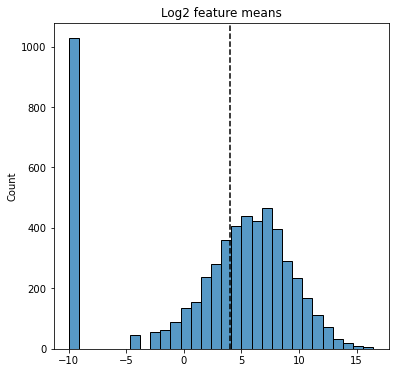

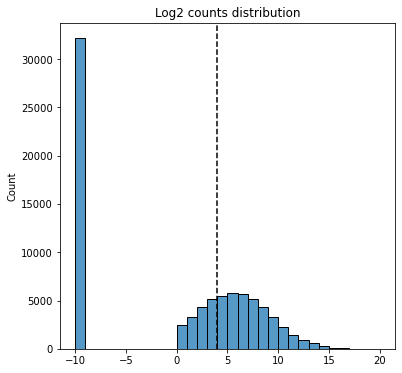

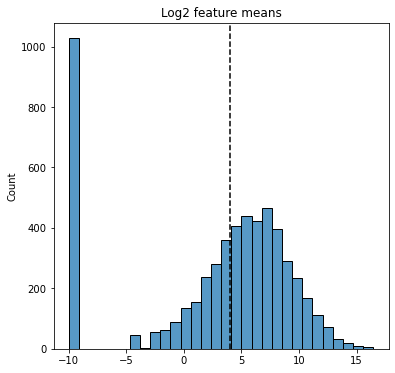

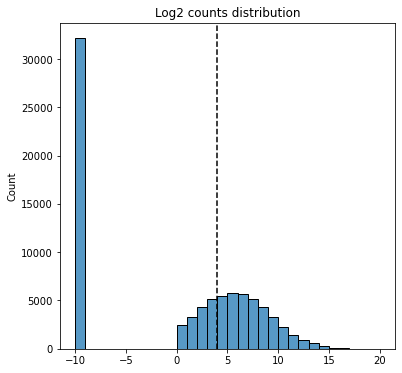

In [103]:
#Exploratory analysis - comparing mcSEED annotated genes to merged_counts 

def reads_distribution_QC(count_df, mcseed_df,cecal_filter=True,pco_col_pat='1C',no_pco_col_pat='2B'):
    bpm1_annotated_count_loci = count_df.loc[count_df.index.isin(mcseed_df.index)]
    if cecal_filter: 
        bpm1_annotated_count_loci = bpm1_annotated_count_loci.loc[:,bpm1_annotated_count_loci.columns.str.contains('cecal')]
        
    bpm_counts_total_entries = len(bpm1_annotated_count_loci)*len(bpm1_annotated_count_loci.columns)
    #BPM mapping and zeroes in all samples
    #1. Total BPM1 loci; 2. fraction of total input loci; 3. hard-coded retained BPM1 loci (based on downstream analysis)
    #4. Zero-expression in all samples 
    print("Total BPM1 mapped loci: {0}".format(len(bpm1_annotated_count_loci)))
    print("BPM1 loci as fraction of total counts: {:.2%}".format(len(bpm1_annotated_count_loci)/len(count_df)))
    print("Retained BPM1 loci: {:.2%}".format(1980/len(bpm1_annotated_count_loci)))
    print("Transcripts with 0 expression in all samples: {0}".format(len(bpm1_annotated_count_loci.loc[bpm1_annotated_count_loci.mean(axis=1)==0])))
    print("")
    #Pco vs no pco sample partitioning; zero-fraction of reads in all, then Pco, no pco partitions
    pco_bpm1_counts= bpm1_annotated_count_loci.loc[:,bpm1_annotated_count_loci.columns.str.contains(pco_col_pat)]
    no_pco_bpm1_counts= bpm1_annotated_count_loci.loc[:,bpm1_annotated_count_loci.columns.str.contains(no_pco_col_pat)]
    zero_fraction_alldata = sum(bpm1_annotated_count_loci.values.flatten()==0)/(len(bpm1_annotated_count_loci)*len(bpm1_annotated_count_loci.columns))
    pco_zero_fraction = sum(pco_bpm1_counts.values.flatten()==0)/(len(pco_bpm1_counts)*len(pco_bpm1_counts.columns))
    no_pco_zero_fraction = sum(no_pco_bpm1_counts.values.flatten()==0)/(len(no_pco_bpm1_counts)*len(no_pco_bpm1_counts.columns))
    print("0 expression as fraction of total dataset: {:.2%}".format(zero_fraction_alldata))
    print("0 expression as fraction of P.copri samples: {:.2%}".format(pco_zero_fraction))
    print("0 expression as fraction of No P.copri samples: {:.2%}".format(no_pco_zero_fraction))
    
    #feature means and log transformed histograms 
    PSEUDOCOUNT = 10**-3
    bpm1_feature_means = bpm1_annotated_count_loci.mean(axis=1)
    log2_feature_means = np.log2(bpm1_feature_means+PSEUDOCOUNT)
    log2_feature_means.replace([np.inf, -np.inf], np.nan, inplace=True)
    print ("===Transcript count means BPM 1 transcripts===")
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    sns.histplot(log2_feature_means,bins=30)
    ymin,ymax = ax.get_ylim()
    ax.vlines(4,ymin,ymax,color='black',linestyles='dashed')
    ax.set_ylim(ymin,ymax)
    ax.set_title("Log2 feature means")
    print("Fraction of Features with avg log2 expression > 4: {:.2%}".format(len(log2_feature_means[log2_feature_means>4])/len(log2_feature_means)))

    fig,ax = plt.subplots(1,1,figsize=(6,6))
    print ("===Transcript counts all data, BPM 1 transcripts===")
    log2_bpm1_counts  = np.log2(bpm1_annotated_count_loci+PSEUDOCOUNT)
    log2_bpm1_counts.replace([np.inf, -np.inf], np.nan, inplace=True)
#     assert(sum(log2_bpm1_counts.isna().values.flatten()))

    sns.histplot(log2_bpm1_counts.values.flatten(),bins=30,binrange=(-10,20))
    ymin,ymax = ax.get_ylim()
    ax.vlines(4,ymin,ymax,color='black',linestyles='dashed')
    ax.set_ylim(ymin,ymax)
    ax.set_title("Log2 counts distribution")
    
reads_distribution_QC(count_df_int,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')
reads_distribution_QC(count_df,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')


In [113]:
cecal_abundance_path = "formatted_input/cecal_abundance.csv"
cecal_abundance_df = pd.read_csv(cecal_abundance_path,sep=",",index_col="MouseID")
cecal_abundance_df.columns = [col.strip() for col in cecal_abundance_df.columns]
# display(cecal_abundance_df)

# ABUNDANCE_SCALING_FACTOR = 10**7 #E7 version
ABUNDANCE_SCALING_FACTOR = 10**6

if ABUNDANCE_SCALING_FACTOR == 10**7:
    AC_TAG = "E7"
elif ABUNDANCE_SCALING_FACTOR == 10**6:
    AC_TAG = "E6"
else:
    AC_TAG = ""

STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Bli463","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
bact_columns = [col.strip() for col in cecal_abundance_df.columns[3:-1].values]
abbrevs_map = dict(zip(bact_columns,STRAIN_ABBREVS))

cecal_abundance_df = cecal_abundance_df.rename(columns=abbrevs_map)
cecal_abundance_converted  = cecal_abundance_df.copy()
cecal_abundance_converted = cecal_abundance_converted.replace("ND",0)
cecal_abundance_converted.loc[:,STRAIN_ABBREVS] = cecal_abundance_converted.loc[:,STRAIN_ABBREVS].astype(float)

for col in STRAIN_ABBREVS:
    cecal_abundance_converted.loc[:,col] = np.power(cecal_abundance_converted.loc[:,col].values,
                                                    [10]*len(cecal_abundance_converted))
    cecal_abundance_converted.loc[:,col] = cecal_abundance_converted.loc[:,col]/(ABUNDANCE_SCALING_FACTOR) #Scale by millions of genome equivalents 

#Drop 1B samples from cecal_abundance 
sample_arm_re=r'[\w_]+[\w_]+_([12][ABC])_[\w+]'
cecal_abundance_converted.loc[:,"Arm"] = cecal_abundance_converted.index.str.extract(sample_arm_re,expand=False)
cecal_abundance_converted = cecal_abundance_converted.loc[~(cecal_abundance_converted["Arm"]=="1B"),:]

    
if ABUNDANCE_SCALING_FACTOR == 10**6:
    cecal_abundance_E6 = cecal_abundance_converted.copy()
    cecal_abundance_E7 = cecal_abundance_converted.copy()
    cecal_abundance_E7.loc[:,STRAIN_ABBREVS] = cecal_abundance_E7.loc[:,STRAIN_ABBREVS]/10
elif ABUNDANCE_SCALING_FACTOR == 10**7:
    cecal_abundance_E6 = cecal_abundance_converted.copy()
    cecal_abundance_E6.loc[:,STRAIN_ABBREVS] = cecal_abundance_E6.loc[:,STRAIN_ABBREVS]*10
    cecal_abundance_E7 = cecal_abundance_converted.copy()
    
with pd.option_context('display.max_columns',None):
    display(cecal_abundance_E6)
    display(cecal_abundance_E7)
    
cecal_abundance_E7.to_csv("{0}/cecal_abundance_E7.csv".format(full_dir_path))
cecal_abundance_E6.to_csv("{0}/cecal_abundance_E6.csv".format(full_dir_path))
    

,Treatment,Mouse Number,Sex,Bbr,Bca,Bli2D9,Bli463,Blu,Rob,Dfo,Dlo,Eav,Eco,FprB,Lga4B6,Lru,Mmu,Pco,Pst,Rgn,Rto,Sga,Spa,Total Bacterial Load,Arm
MouseID,,,,,,,,,,,,,,,,,,,,,,,,,
Pup_1-cecal_contents_53_1C_Pup_1,Arm 1 (Pre-weaning P. copri colonization),1,female,56.553905,90.949470,5.149066,0.0,0.012089,79.956107,0.000000,82.586011,46.145406,447.754281,0.000000,31.431359,5.259913,19.572572,423.911583,113.503324,136.713023,69.029669,26.745536,52.870944,7.75,1C
Pup_2-cecal_contents_53_1C_Pup_2,Arm 1 (Pre-weaning P. copri colonization),2,male,18.504276,64.620362,1.708020,0.0,0.005137,48.571444,0.000070,111.739516,42.343391,312.028410,0.000075,17.161558,2.211937,13.124183,244.619406,72.512370,126.568368,29.264559,22.698073,45.361306,7.48,1C
Pup_3-cecal_contents_53_1C_Pup_3,Arm 1 (Pre-weaning P. copri colonization),3,male,86.676995,241.097229,5.725104,0.0,0.005137,95.410558,0.002014,161.651558,61.481538,359.080281,0.000470,20.696059,34.952911,52.870944,485.785317,86.676995,138.827645,55.612146,29.264559,83.929937,7.82,1C
Pup_4-cecal_contents_53_1C_Pup_4,Arm 1 (Pre-weaning P. copri colonization),4,male,95.410558,259.175953,6.768156,0.0,0.015833,108.285712,0.000000,147.583700,71.334291,435.686165,0.000000,30.876539,26.745536,62.512219,447.754281,134.627433,130.541939,48.571444,25.793839,78.669633,7.85,1C
Pup_5-cecal_contents_53_1C_Pup_5,Arm 1 (Pre-weaning P. copri colonization),5,female,122.703987,325.524355,19.940813,0.0,0.292029,187.798764,0.005591,161.651558,82.586011,447.754281,0.000000,33.150072,36.203333,103.284963,453.900435,145.349319,136.713023,52.870944,2.316749,88.080641,7.91,1C
Pup_6-cecal_contents_53_1C_Pup_6,Arm 1 (Pre-weaning P. copri colonization),6,male,171.688929,429.762583,11.904242,0.0,0.112590,111.739516,0.004326,251.803026,118.946120,533.811929,0.000000,51.984612,50.251953,95.410558,466.421051,140.971660,182.283780,54.684526,6.909893,159.226224,8.03,1C
Pup_7-cecal_contents_53_1C_Pup_7,Arm 1 (Pre-weaning P. copri colonization),7,male,104.928286,266.742610,7.817873,0.0,0.172769,182.283780,0.010328,190.612177,89.504711,447.754281,0.000000,25.329516,10.787325,59.465931,695.484886,138.827645,255.465552,83.929937,16.523656,143.145429,8.04,1C
Pup_8-cecal_contents_53_1C_Pup_8,Arm 1 (Pre-weaning P. copri colonization),8,female,85.293513,255.465552,30.876539,0.0,0.036615,124.622697,0.012570,227.460356,106.595103,634.479740,0.000000,36.203333,12.379400,66.792276,586.070366,0.028579,248.187825,154.473557,21.083252,227.460356,8.07,1C
Pup_1-cecal_contents_54_2B_Pup_1,Arm 3 (No P. copri colonization),1,male,19.210462,83.929937,0.000000,0.0,0.206438,0.679184,0.014669,241.097229,274.507507,995.875445,0.000000,73.707931,0.157863,0.144125,0.000000,0.000000,695.484886,190.612177,5.847040,266.742610,8.22,2B


,Treatment,Mouse Number,Sex,Bbr,Bca,Bli2D9,Bli463,Blu,Rob,Dfo,Dlo,Eav,Eco,FprB,Lga4B6,Lru,Mmu,Pco,Pst,Rgn,Rto,Sga,Spa,Total Bacterial Load,Arm
MouseID,,,,,,,,,,,,,,,,,,,,,,,,,
Pup_1-cecal_contents_53_1C_Pup_1,Arm 1 (Pre-weaning P. copri colonization),1,female,5.655390,9.094947,0.514907,0.0,0.001209,7.995611,0.000000,8.258601,4.614541,44.775428,0.000000,3.143136,0.525991,1.957257,42.391158,11.350332,13.671302,6.902967,2.674554,5.287094,7.75,1C
Pup_2-cecal_contents_53_1C_Pup_2,Arm 1 (Pre-weaning P. copri colonization),2,male,1.850428,6.462036,0.170802,0.0,0.000514,4.857144,0.000007,11.173952,4.234339,31.202841,0.000008,1.716156,0.221194,1.312418,24.461941,7.251237,12.656837,2.926456,2.269807,4.536131,7.48,1C
Pup_3-cecal_contents_53_1C_Pup_3,Arm 1 (Pre-weaning P. copri colonization),3,male,8.667700,24.109723,0.572510,0.0,0.000514,9.541056,0.000201,16.165156,6.148154,35.908028,0.000047,2.069606,3.495291,5.287094,48.578532,8.667700,13.882765,5.561215,2.926456,8.392994,7.82,1C
Pup_4-cecal_contents_53_1C_Pup_4,Arm 1 (Pre-weaning P. copri colonization),4,male,9.541056,25.917595,0.676816,0.0,0.001583,10.828571,0.000000,14.758370,7.133429,43.568617,0.000000,3.087654,2.674554,6.251222,44.775428,13.462743,13.054194,4.857144,2.579384,7.866963,7.85,1C
Pup_5-cecal_contents_53_1C_Pup_5,Arm 1 (Pre-weaning P. copri colonization),5,female,12.270399,32.552436,1.994081,0.0,0.029203,18.779876,0.000559,16.165156,8.258601,44.775428,0.000000,3.315007,3.620333,10.328496,45.390044,14.534932,13.671302,5.287094,0.231675,8.808064,7.91,1C
Pup_6-cecal_contents_53_1C_Pup_6,Arm 1 (Pre-weaning P. copri colonization),6,male,17.168893,42.976258,1.190424,0.0,0.011259,11.173952,0.000433,25.180303,11.894612,53.381193,0.000000,5.198461,5.025195,9.541056,46.642105,14.097166,18.228378,5.468453,0.690989,15.922622,8.03,1C
Pup_7-cecal_contents_53_1C_Pup_7,Arm 1 (Pre-weaning P. copri colonization),7,male,10.492829,26.674261,0.781787,0.0,0.017277,18.228378,0.001033,19.061218,8.950471,44.775428,0.000000,2.532952,1.078733,5.946593,69.548489,13.882765,25.546555,8.392994,1.652366,14.314543,8.04,1C
Pup_8-cecal_contents_53_1C_Pup_8,Arm 1 (Pre-weaning P. copri colonization),8,female,8.529351,25.546555,3.087654,0.0,0.003662,12.462270,0.001257,22.746036,10.659510,63.447974,0.000000,3.620333,1.237940,6.679228,58.607037,0.002858,24.818783,15.447356,2.108325,22.746036,8.07,1C
Pup_1-cecal_contents_54_2B_Pup_1,Arm 3 (No P. copri colonization),1,male,1.921046,8.392994,0.000000,0.0,0.020644,0.067918,0.001467,24.109723,27.450751,99.587545,0.000000,7.370793,0.015786,0.014412,0.000000,0.000000,69.548489,19.061218,0.584704,26.674261,8.22,2B


In [99]:
def vc_strain_locus_tag(expr_df,mcseed_df):
    """Returns a DataFrame indexed on locus tags for each strain, containing columns: 
        "Filtered Loci" - number of loci corresponding to that locus tag (ie loci per strain)
        "Strain" - full strain name corresponding to locus tag 
        :param pd.DataFrame expr_df: DataFrame indexed by ORFs containing (transformed) expression data, columns
        are samples 
        :param pd.DataFrame mcseed_df: DataFrame containing mcSEED annotations for loci, not necessarily for 
        all loci in expr_df 
    """
    vc_by_strain_locus_tag = expr_df.index.str.extract(r'(\w+)_\d+',expand=False).value_counts()
#     vc_by_strain_locus_tag.drop("ROSSTS7063_a2",inplace=True) #2nd3rd_trial specific error 
    locus_tag_strains = [mcseed_df.loc[mcseed_df.index.str.contains(lt),"Isolate name"].values[0] 
                             for lt in vc_by_strain_locus_tag.index] #if lt != "ROSSTS7063_a2"]
    locus_vc_df = pd.DataFrame(index=vc_by_strain_locus_tag.index,columns=["Filtered Loci","Strain"])
    locus_vc_df.loc[:,"Filtered Loci"] = vc_by_strain_locus_tag
    locus_vc_df.loc[:,"Strain"] = locus_tag_strains
    locus_vc_df.loc[:,"Abbreviation"] = [STRAIN_TAGS[lts] for lts in locus_tag_strains]
    return locus_vc_df

def abundance_correct_expr_df(expr_df,abundance_df,locus_vc_df):
    abundance_corrected = expr_df.copy()
    abundance_corrected = abundance_corrected.loc[:,abundance_corrected.columns.isin(abundance_df.index)]
    abundance_corrected.loc[:,"Locus Tag"] = abundance_corrected.index.str.extract(r'(\w+)_\d+',expand=False)
    for lt in abundance_corrected["Locus Tag"].unique():
        strain_abbrev = locus_vc_df.loc[lt,"Abbreviation"]
        lt_expr_df = abundance_corrected.loc[abundance_corrected.loc[:,"Locus Tag"]==lt]
        abundance_data = abundance_df.loc[:,strain_abbrev]
        samples = list(abundance_data.index)
        lt_ac = lt_expr_df.loc[:,lt_expr_df.columns.isin(samples)]/abundance_data
        abundance_corrected.loc[lt_ac.index,samples] = lt_ac.loc[:,samples]
    abundance_corrected.drop(columns="Locus Tag",inplace=True)
#     display(abundance_corrected.loc[np.isinf(abundance_corrected).any(axis=1),:])
    abundance_corrected.replace([np.inf, -np.inf], np.nan, inplace=True)

    abundance_corrected.replace(np.nan,0,inplace=True)
    abundance_corrected = abundance_corrected.astype('float')
    return abundance_corrected
    
locus_vc_df = vc_strain_locus_tag(count_df,mcseed_df)
# display(locus_vc_df)
abundance_corrected_expr = abundance_correct_expr_df(count_df,cecal_abundance_converted,locus_vc_df)
assert(len(count_df.loc[count_df.isna().any(axis=1)])==0)
assert(len(abundance_corrected_expr.loc[abundance_corrected_expr.isna().any(axis=1)])==0)
abundance_corrected_expr_int = np.floor(abundance_corrected_expr)
abundance_corrected_expr_int = abundance_corrected_expr_int.astype('int')
display(abundance_corrected_expr)
display(abundance_corrected_expr_int)

filt_tpm = tpm_df.loc[:,tpm_df.columns.isin(abundance_corrected_expr.columns)]
    
for abundance_data,tag in [(cecal_abundance_E6,"E6"),(cecal_abundance_E7,"E7")]:
    ac_expr_data = abundance_correct_expr_df(count_df,abundance_data,locus_vc_df) 
    ac_expr_int = np.floor(ac_expr_data).astype(int)
    filt_tpm = tpm_df.loc[:,tpm_df.columns.isin(ac_expr_data.columns)]
    
    if tag == "E6":
        ac_float_E6 = ac_expr_data
        ac_int_E6 = ac_expr_int
    elif tag == "E7":
        ac_float_E7 = ac_expr_data
        ac_int_E7 = ac_expr_int
    
    full_dir_path = "formatted_output/4th_trial/full/".format(tag)
    if not os.path.exists(full_dir_path):
        os.makedirs(full_dir_path)
    if overwrite_files or not os.path.exists("{0}/{1}/abundance_corrected_count.csv".format(full_dir_path,tag)):
        ac_expr_data.to_csv("{0}/{1}/abundance_corrected_count.csv".format(full_dir_path,tag))
        ac_expr_int.to_csv("{0}/{1}/abundance_corrected_count_int.csv".format(full_dir_path,tag))
        filt_tpm.to_csv("{0}/{1}/column_filtered_tpm.csv".format(full_dir_path,tag))

,Pup_1-cecal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_6-cecal_contents_53_1C_Pup_6,Pup_7-cecal_contents_53_1C_Pup_7,Pup_8-cecal_contents_53_1C_Pup_8,Pup_1-cecal_contents_54_2B_Pup_1,Pup_2-cecal_contents_54_2B_Pup_2,Pup_3-cecal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,
ANCJAENF_00001,558.628092,517.432304,324.425183,635.533436,521.362848,305.134410,287.727944,558.256992,793.546747,335.216732,227.794711,70.533942,120.033003,2224.940970,1386.412460
ANCJAENF_00002,10857.747149,11235.133083,8839.992654,11932.851245,9604.985388,6970.630002,4706.852830,10473.750809,12058.220895,4577.978635,4632.045540,1346.551576,2137.291444,38711.753721,22101.882732
ANCJAENF_00003,558.628092,517.432304,324.425183,635.533436,521.362848,305.134410,287.727944,558.256992,793.546747,335.216732,227.794711,70.533942,120.033003,2224.940970,1386.412460
ANCJAENF_00004,10857.747149,11235.133083,8839.992654,11932.851245,9604.985388,6970.630002,4706.852830,10473.750809,12058.220895,4577.978635,4632.045540,1346.551576,2137.291444,38711.753721,22101.882732
ANCJAENF_00005,0.335963,0.108083,0.103834,0.083848,0.016299,0.023298,0.066712,0.011724,0.156165,0.000000,0.000000,0.000000,0.173056,0.000000,0.345889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LDOIJNDB_02260,0.005404,0.028344,0.010213,0.010895,0.004866,0.002692,0.003992,0.002512,0.006962,0.022077,0.004495,0.022743,0.015743,0.009559,0.009690
LDOIJNDB_02261,113.441515,470.165037,103.481313,116.225660,121.855380,69.495462,91.984076,113.389429,171.556018,131.171218,182.373936,346.084059,44.934449,650.928024,251.725423


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_6-cecal_contents_53_1C_Pup_6,Pup_7-cecal_contents_53_1C_Pup_7,Pup_8-cecal_contents_53_1C_Pup_8,Pup_1-cecal_contents_54_2B_Pup_1,Pup_2-cecal_contents_54_2B_Pup_2,Pup_3-cecal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,
ANCJAENF_00001,558,517,324,635,521,305,287,558,793,335,227,70,120,2224,1386
ANCJAENF_00002,10857,11235,8839,11932,9604,6970,4706,10473,12058,4577,4632,1346,2137,38711,22101
ANCJAENF_00003,558,517,324,635,521,305,287,558,793,335,227,70,120,2224,1386
ANCJAENF_00004,10857,11235,8839,11932,9604,6970,4706,10473,12058,4577,4632,1346,2137,38711,22101
ANCJAENF_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LDOIJNDB_02260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LDOIJNDB_02261,113,470,103,116,121,69,91,113,171,131,182,346,44,650,251


==E6 float==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1032

0 expression as fraction of total dataset: 38.90%
0 expression as fraction of P.copri samples: 26.94%
0 expression as fraction of No P.copri samples: 52.57%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 3.46%
===Transcript counts all data, BPM 1 transcripts===
==E7 float==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1032

0 expression as fraction of total dataset: 38.90%
0 expression as fraction of P.copri samples: 26.94%
0 expression as fraction of No P.copri samples: 52.57%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 21.40%
===Transcript counts all data, BPM 1 transcripts===


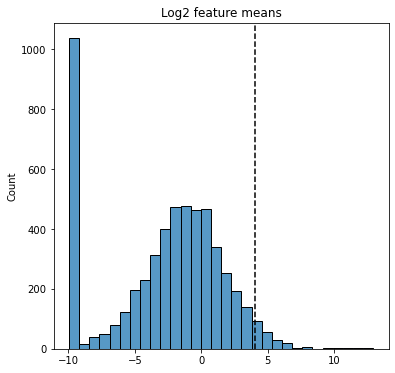

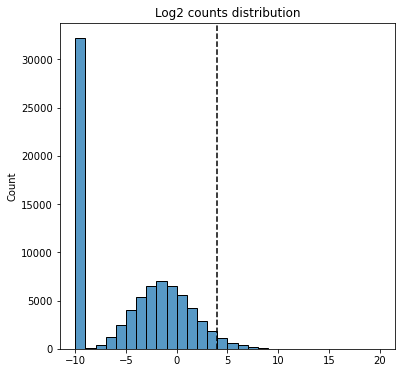

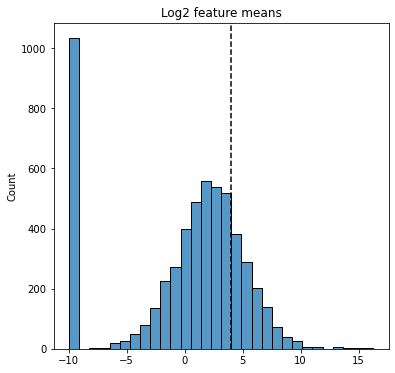

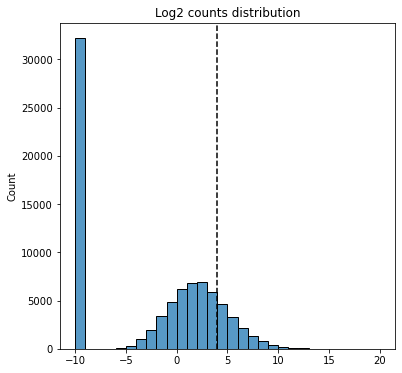

In [104]:
#Float AC counts
print("==E6 float==")
reads_distribution_QC(ac_float_E6,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')
print("==E7 float==")
reads_distribution_QC(ac_float_E7,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')

==E6 int==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 2744

0 expression as fraction of total dataset: 79.48%
0 expression as fraction of P.copri samples: 78.70%
0 expression as fraction of No P.copri samples: 80.37%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 3.37%
===Transcript counts all data, BPM 1 transcripts===
==E7 int==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1324

0 expression as fraction of total dataset: 52.95%
0 expression as fraction of P.copri samples: 46.23%
0 expression as fraction of No P.copri samples: 60.63%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 21.02%
===Transcript counts all data, BPM 1 transcripts===


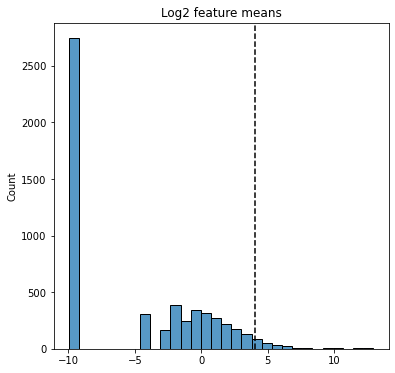

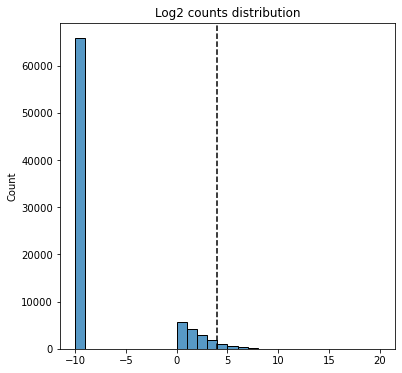

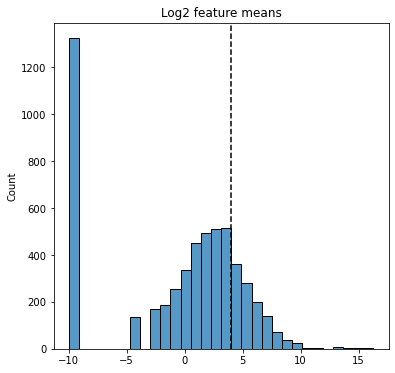

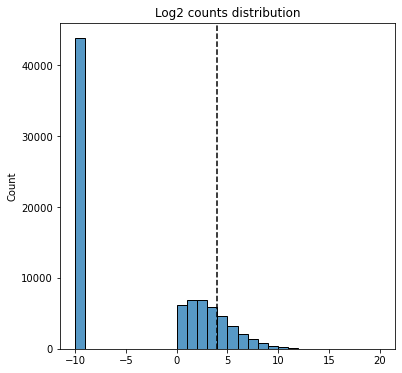

In [105]:
#Int AC counts
print("==E6 int==")
reads_distribution_QC(ac_int_E6,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')
print("==E7 int==")
reads_distribution_QC(ac_int_E7,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')

In [142]:
edger_filtered_counts_fpath = "formatted_output/4th_trial/edgeR_filtered/edgeR_filtered_count.csv"
edger_filtered_counts = pd.read_csv(edger_filtered_counts_fpath,index_col=0)
edger_filtered_counts.index.name = "target_id"
edger_filtered_counts.columns = [col.replace(".","-") for col in edger_filtered_counts.columns]
# display(edger_filtered_counts)
edgeR_AC_expr = abundance_correct_expr_df(edger_filtered_counts,cecal_abundance_E7,locus_vc_df)

edgeR_AC_int = np.ceil(edgeR_AC_expr).astype(int)
# display(edgeR_AC_expr)
display(edgeR_AC_int)

edgeR_AC_int.to_csv("formatted_output/4th_trial/edgeR_filtered/edgeR_filt_AC.csv")

,Pup_1-cecal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_6-cecal_contents_53_1C_Pup_6,Pup_7-cecal_contents_53_1C_Pup_7,Pup_8-cecal_contents_53_1C_Pup_8,Pup_1-cecal_contents_54_2B_Pup_1,Pup_2-cecal_contents_54_2B_Pup_2,Pup_3-cecal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,
ANCJAENF_00001,5587,5175,3245,6356,5214,3052,2878,5583,7936,3360,2280,741,1201,22251,13865
ANCJAENF_00002,108578,112352,88400,119329,96050,69707,47069,104738,120583,45782,46325,13529,21373,387118,221019
ANCJAENF_00003,5587,5175,3245,6356,5214,3052,2878,5583,7936,3360,2280,741,1201,22251,13865
ANCJAENF_00004,108578,112352,88400,119329,96050,69707,47069,104738,120583,45782,46325,13529,21373,387118,221019
ANCJAENF_00006,14,16,9,4,5,2,6,3,12,0,22,0,13,5,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02252,8,4,7,2,1,1,3,6,8,2,6,12,7,2,6
LDOIJNDB_02253,13,15,11,2,3,1,8,12,21,8,12,26,11,7,16
LDOIJNDB_02254,2,2,1,1,1,0,1,1,2,2,1,4,1,1,2
